In [1]:
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt


from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from scipy.ndimage.morphology import binary_erosion
from tqdm import tqdm

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            # Conv2d layers expect input with the shape (n_samples, channels, height, width) 
            # e.g., (1000, 1, 224, 224), source https://pytorch.org/docs/stable/nn.html#conv2d
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=1, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_IMG_DIR = "evaluation/images/"
TRAIN_MASK_DIR = "evaluation/masks/"
MODEL = 'mix_bs_12_lr_0.0001_loss_dice_bce_weight_0.5_aug_True.pth'
NUM_WORKERS = 4
BATCH_SIZE = 12
OUTOUT_FOLDER = "evaluation/outputs/"

In [4]:
model = UNET().to(DEVICE)
model.load_state_dict(torch.load(f'model_outputs/{MODEL}'))

<All keys matched successfully>

In [5]:
#dataset.py
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
from torch.utils.data import DataLoader

class LungNoduleDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
         return len(self.images)


    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        image = np.array(np.load(img_path)).astype('float')
        mask = np.array(np.load(mask_path)).astype('float')
#         assert np.array_equal(np.unique(mask), np.array([0.,1.]))
        if self.transform is None:
            image = np.expand_dims(image, 0)
            mask = np.expand_dims(mask, 0)
        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
        return image, mask

In [6]:
test_ds = LungNoduleDataset(
        image_dir=TRAIN_IMG_DIR,
        mask_dir=TRAIN_MASK_DIR,
        transform=None,
    )
test_loader = DataLoader(
        test_ds,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=False,
        shuffle=True,
    )

In [7]:
device = DEVICE
with torch.no_grad():
    pbar = tqdm(total=len(test_loader))
    for idx,(data, target) in enumerate(test_loader):
        if idx == 1000:
            break
        data = data.to(device).float()
        output = model(data)
        output = torch.sigmoid(output)
        output = output.float().cpu().numpy().squeeze(1)
        target = target.float().squeeze(1).cpu().numpy()
        image = data.cpu().numpy()
        #assert np.array_equal(np.unique(target), np.array([0.,1.]))
        if idx == 0:
            predictions = output
            targets = target
            images = image
        else:
            predictions = np.concatenate([predictions, output])
            targets = np.concatenate([targets, target])
            images = np.concatenate([images, image])
        pbar.update(1)
    pbar.close()

 16%|█▋        | 1000/6148 [32:23<2:46:44,  1.94s/it]


In [8]:
print(predictions.shape, targets.shape)

(12000, 256, 256) (12000, 256, 256)


In [9]:
# Post-processing
predictions = np.where(predictions>0.5, 1, 0)

In [10]:
print(predictions.shape, targets.shape)

(12000, 256, 256) (12000, 256, 256)


In [11]:
predictions# Performance checking

y_scores = predictions.reshape(predictions.shape[0] * predictions.shape[1] * predictions.shape[2], 1)
print(y_scores.shape)

y_true = targets.reshape(targets.shape[0] * targets.shape[1] * targets.shape[2], 1)
print(y_true.shape)

# y_scores = np.where(y_scores>0.5, 1, 0)
# y_true   = np.where(y_true>0.5, 1, 0)

# output_folder = 'output/'
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)    

(786432000, 1)
(786432000, 1)



Area under the ROC curve: 0.9754917587985069


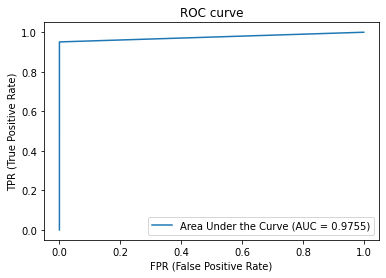

In [15]:
#Area under the ROC curve
fpr, tpr, thresholds = roc_curve((y_true), y_scores)
AUC_ROC = roc_auc_score(y_true, y_scores)
print ("\nArea under the ROC curve: " +str(AUC_ROC))
roc_curve =plt.figure()
plt.plot(fpr,tpr,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_ROC)
plt.title('ROC curve')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.legend(loc="lower right")
plt.savefig(OUTOUT_FOLDER + "ROC.png")


Area under Precision-Recall curve: 0.9208993558006666


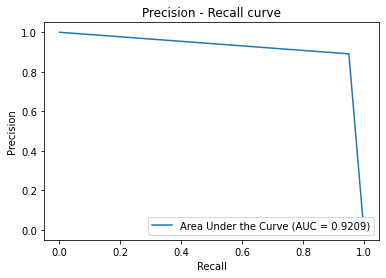

In [16]:
#Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
precision = np.fliplr([precision])[0] 
recall = np.fliplr([recall])[0]
AUC_prec_rec = np.trapz(precision,recall)
print ("\nArea under Precision-Recall curve: " +str(AUC_prec_rec))
prec_rec_curve = plt.figure()
plt.plot(recall,precision,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_prec_rec)
plt.title('Precision - Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower right")
plt.savefig(OUTOUT_FOLDER + "Precision_recall.png")

In [12]:
#Confusion matrix
threshold_confusion = 0.5
print ("\nConfusion matrix:  Custom threshold (for positive) of " +str(threshold_confusion))
y_pred = np.empty((y_scores.shape[0]))
for i in range(y_scores.shape[0]):
    if y_scores[i]>=threshold_confusion:
        y_pred[i]=1
    else:
        y_pred[i]=0
confusion = confusion_matrix(y_true, y_pred)
print (confusion)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print ("Global Accuracy: " +str(accuracy))
specificity = 0
if float(confusion[0,0]+confusion[0,1])!=0:
    specificity = float(confusion[0,0])/float(confusion[0,0]+confusion[0,1])
print ("Specificity: " +str(specificity))
sensitivity = 0
if float(confusion[1,1]+confusion[1,0])!=0:
    sensitivity = float(confusion[1,1])/float(confusion[1,1]+confusion[1,0])
print ("Sensitivity: " +str(sensitivity))
precision = 0
if float(confusion[1,1]+confusion[0,1])!=0:
    precision = float(confusion[1,1])/float(confusion[1,1]+confusion[0,1])
print ("Precision: " +str(precision))


Confusion matrix:  Custom threshold (for positive) of 0.5
[[786025704     42446]
 [    17815    346035]]
Global Accuracy: 0.9999233741760254
Specificity: 0.9999460021373465
Sensitivity: 0.9510375154596674
Precision: 0.8907385431977368


In [ ]:
# #Jaccard similarity index
# jaccard_index = jaccard_similarity_score(y_true, y_pred, normalize=True)
# print ("\nJaccard similarity score: " +str(jaccard_index))

In [ ]:
# Dice coefficient
def get_dice_coef(output, target):
    "This metric is for validation purpose"
    smooth = 1e-5
    intersection = (output * target).sum()
    return (2. * intersection + smooth) / \
        (output.sum() + target.sum() + smooth)
dice_coef = get_dice_coef(y_scores, y_true)

In [13]:
#F1 score
F1_score = f1_score(y_true, y_pred, labels=None, average='binary', sample_weight=None)
print ("\nF1 score (F-measure): " +str(F1_score))


F1 score (F-measure): 0.9199009478540696


In [17]:
evaluation_metrics = f"""
Area under the ROC curve: {str(AUC_ROC)}
\nArea under Precision-Recall curve: {str(AUC_prec_rec)}
\nF1 score (F-measure): {str(F1_score)}
\nConfusion matrix: \n{str(confusion)}
\nAccuracy: {str(accuracy)}
\nSensitivity: {str(sensitivity)}
\nSpecitivity: {str(specificity)}
\nPrecision: {str(precision)}
"""
print(evaluation_metrics)


Area under the ROC curve: 0.9754917587985069

Area under Precision-Recall curve: 0.9208993558006666

F1 score (F-measure): 0.9199009478540696

Confusion matrix: 
[[786025704     42446]
 [    17815    346035]]

Accuracy: 0.9999233741760254

Sensitivity: 0.9510375154596674

Specitivity: 0.9999460021373465

Precision: [1.00000000e+00 8.90738543e-01 4.62659200e-04]



In [ ]:
# #Save the results
# file_perf = open(output_folder+'performances.txt', 'w')
# file_perf.write(evaluation_metrics)
# file_perf.close()

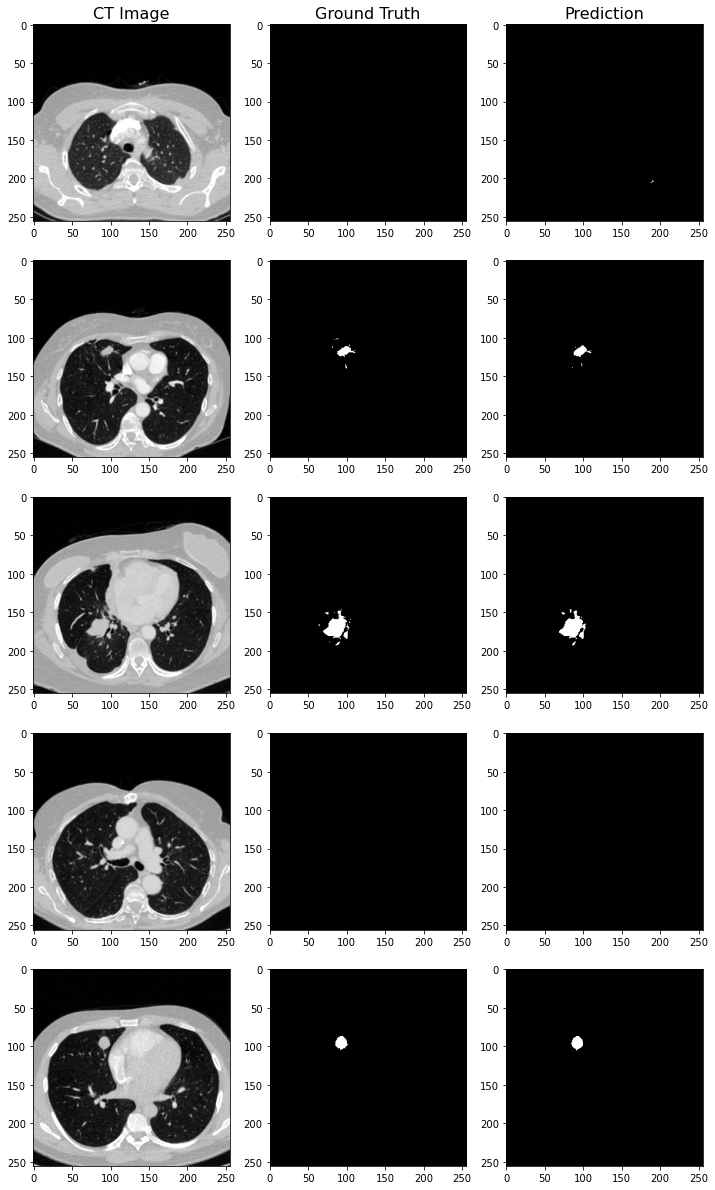

In [53]:
# Sample results
fig,ax = plt.subplots(5, 3, figsize=[12,21])
list_axes = list(ax.flat)
title_fontsize = 16
list_axes[0].set_title('CT Image', fontsize=title_fontsize)
list_axes[1].set_title('Ground Truth', fontsize=title_fontsize) 
list_axes[2].set_title('Prediction', fontsize=title_fontsize) 
# all_ind = np.random.randint(0, len(targets), 5) # random samples
# all_ind = np.array(all_ind)
all_ind = [5552, 10568, 5232, 1221, 7469] 
for idx in range(5):
    ax[idx, 0].imshow(np.squeeze(images[all_ind[idx]]), cmap='gray')  
    ax[idx, 1].imshow(np.squeeze(targets[all_ind[idx]]), cmap='gray')  
    ax[idx, 2].imshow(np.uint8(np.squeeze(predictions[all_ind[idx]])), cmap='gray')
plt.savefig(OUTOUT_FOLDER + "Examples.png")